## MSstatsTMT Analysis：Proteomics differential expression downstream analysis

#### The following Jupyter notebooks allows to perform differential expression data analysis from multiple pipelines developed by the bigbio team. The output of the following pipelines are supported: 

- [proteomicsTMT](https://github.com/bigbio/proteomicstmt): TMT pipeline based on OpenMS and nextflow.

For the data with isobaric labeling, using the [MSstatsTMT](https://www.bioconductor.org/packages/release/bioc/html/MSstatsTMT.html) to perform the downstream data analysis. Major steps in the data processing are the following:

- Importing data from the pipeline. The major source of data are:
  - out.mzTab
  - metadata.sdrf.tsv or experimental_design.tsv 

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
# preprocess out_msstats.csv

import pandas as pd

def remove_decoy(Pro):
    if "CONTAMINANT" in Pro or "DECOY_" in Pro:
        return None
    else:
        return Pro
    
data = pd.read_csv("../datasets/PXD007096/out_msstats.csv", sep=",")
data['ProteinName'] = data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
data.dropna(axis=0, how='any', inplace=True, subset=['ProteinName'])

membrane_data = data[data["Condition"].str.contains("membrane")]
soluble_data = data[data["Condition"].str.contains("soluble")]
# split to two datasets: membrane fraction and souble fraction
membrane_data.to_csv("../datasets/PXD007096/out_msstats_membrane.csv", index=False, sep=",")
soluble_data.to_csv("../datasets/PXD007096/out_msstats_soluble.csv", index=False, sep=",")

### Comparing the number of quantified proteins and identified proteins

#### proteomicstmt identified and quantified more proteins. And most of the proteins given in the article is in proteomicstmt result

{'P68370', 'P58775', 'P85108,Q3KRE8', 'Q6IE52', 'Q6P9V9'}


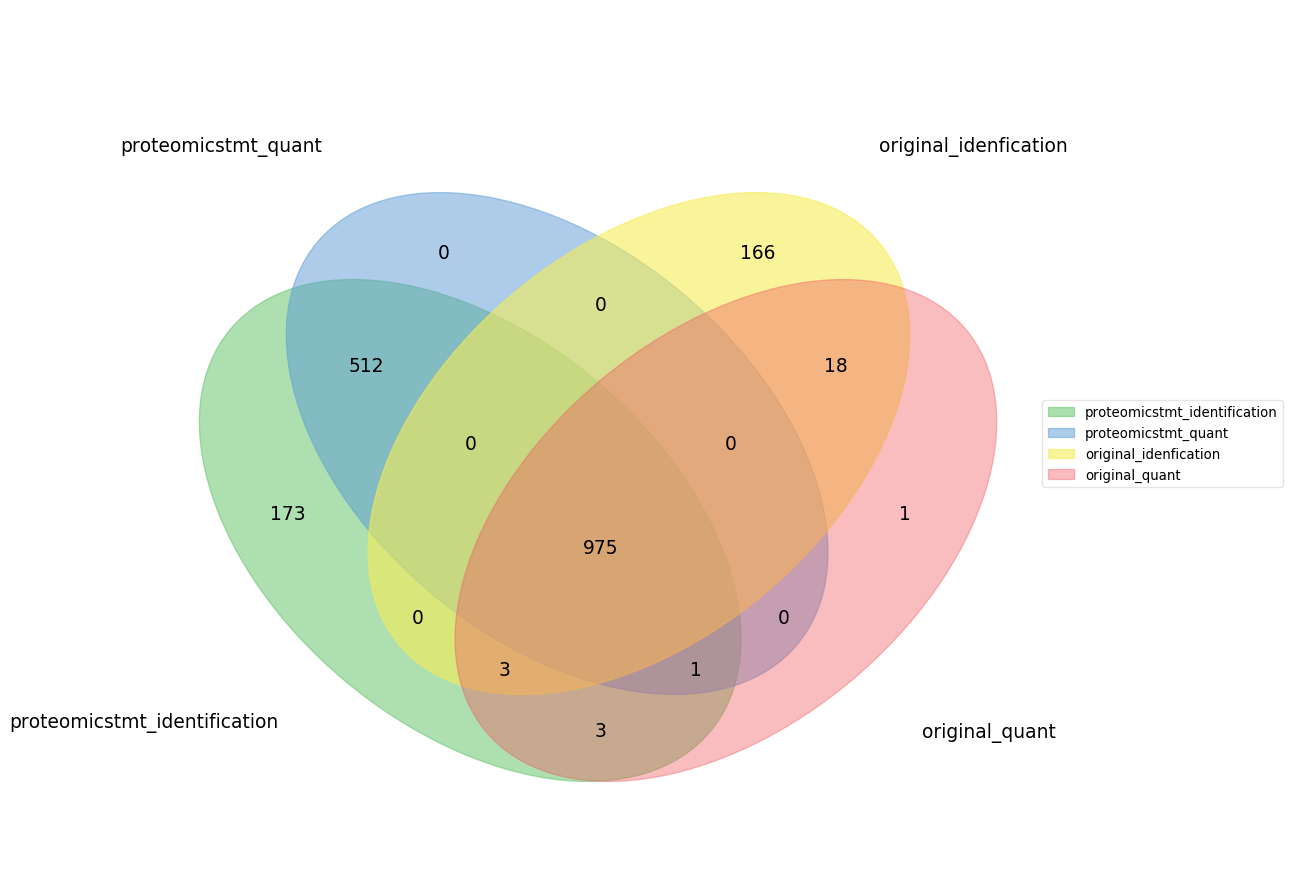

In [45]:
import gzip
from pyvenn import venn
from pyteomics import mztab

# path = "./out.mzTab.gz"
# f_name = path.replace(".gz", "")
# g_file = gzip.GzipFile(path)
# with open(f_name, "wb+") as f:
#     f.write(g_file.read())
    
def compare_preprocess(proteins):
    if "," in proteins:
        s_protein = ','.join(sorted(proteins.replace(" ", "").split(",")))
        return s_protein
    else:
        return proteins
    
original_membrane_result = pd.read_excel("./Membrane_fraction.xlsx", sheet_name="Identifications")
original_soluble_result = pd.read_excel("./Soluble_fraction.xlsx", sheet_name="Identifications")

quant_membrane_result = pd.read_excel("./Membrane_fraction.xlsx", sheet_name="Quantifications")
quant_soluble_result = pd.read_excel("./Soluble_fraction.xlsx", sheet_name="Quantifications")

original_membrane_result['Accessions'] = original_membrane_result.apply(lambda x: compare_preprocess(x["Accessions"]), axis = 1)
original_soluble_result['Accessions'] = original_soluble_result.apply(lambda x: compare_preprocess(x["Accessions"]), axis = 1)
quant_membrane_result['AC'] = quant_membrane_result.apply(lambda x: compare_preprocess(x["AC"]), axis = 1)
quant_soluble_result['AC'] = quant_soluble_result.apply(lambda x: compare_preprocess(x["AC"]), axis = 1)

total_identification_prot = set(original_membrane_result['Accessions']).union(set(original_soluble_result['Accessions']))
total_quant_prot = set(quant_membrane_result['AC']).union(set(quant_soluble_result['AC']))

quant_data = pd.read_csv("./out_msstats.csv", sep=",")
quant_data['ProteinName'] = quant_data.apply(lambda x: remove_decoy(x.ProteinName), axis=1)
quant_data.dropna(axis=0, how='any', inplace=True, subset=['ProteinName'])
quant_data['AC'] = quant_data.apply(lambda x: x.ProteinName.split("|")[1], axis = 1)

prot_table = mztab.MzTab("./out.mzTab").protein_table
prot_table['accession'] = prot_table.apply(lambda x: remove_decoy(x.accession), axis = 1)
prot_table.dropna(axis=0, how='any', inplace=True, subset=['accession'])
prot_table['Accessions'] = prot_table.apply(lambda x: x.accession.split("|")[1], axis = 1)

labels = venn.get_labels([set(prot_table['Accessions']), set(quant_data['AC']), total_identification_prot, total_quant_prot], fill=["number"])
venn.venn4(labels, names=["proteomicstmt_identification", "proteomicstmt_quant", "original_idenfication", "original_quant"], fig_size=(5, 10))
print(total_quant_prot - total_identification_prot)

### Soluble Fraction

In [4]:
%%R -w 800 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
data_folder = '../datasets/PXD007096'
setwd(data_folder)
openms_output = './out_msstats_soluble.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

raw.om$Condition[which(raw.om$Condition == "soluble fraction of pancreas|control")] <- "control"
raw.om$Condition[which(raw.om$Condition == "soluble fraction of pancreas|acute pancreatitis")] <- "acute pancreatitis"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

INFO  [2021-10-21 11:20:25] ** Raw data from OpenMS imported successfully.
INFO  [2021-10-21 11:20:25] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-10-21 11:20:25] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-10-21 11:20:25] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-10-21 11:20:25] ** Shared peptides are removed.
INFO  [2021-10-21 11:20:25] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-10-21 11:20:30] ** PSMs have been aggregated to peptide ions.
INFO  [2021-10-21 11:20:31] ** For peptides overlapped between fractions of 1_1_1 use the fraction with maximal average abundance.
INFO  [2021-10-21 11:20:31] ** Fractions belongin

### Protein summarization, normalization and visualization

INFO  [2021-10-21 11:20:37] ** MSstatsTMT - proteinSummarization function
INFO  [2021-10-21 11:20:37] Summarizing for Run : 1_1_1 ( 1  of  1 )
  |======================================================================| 100%
INFO  [2021-10-21 11:20:45] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


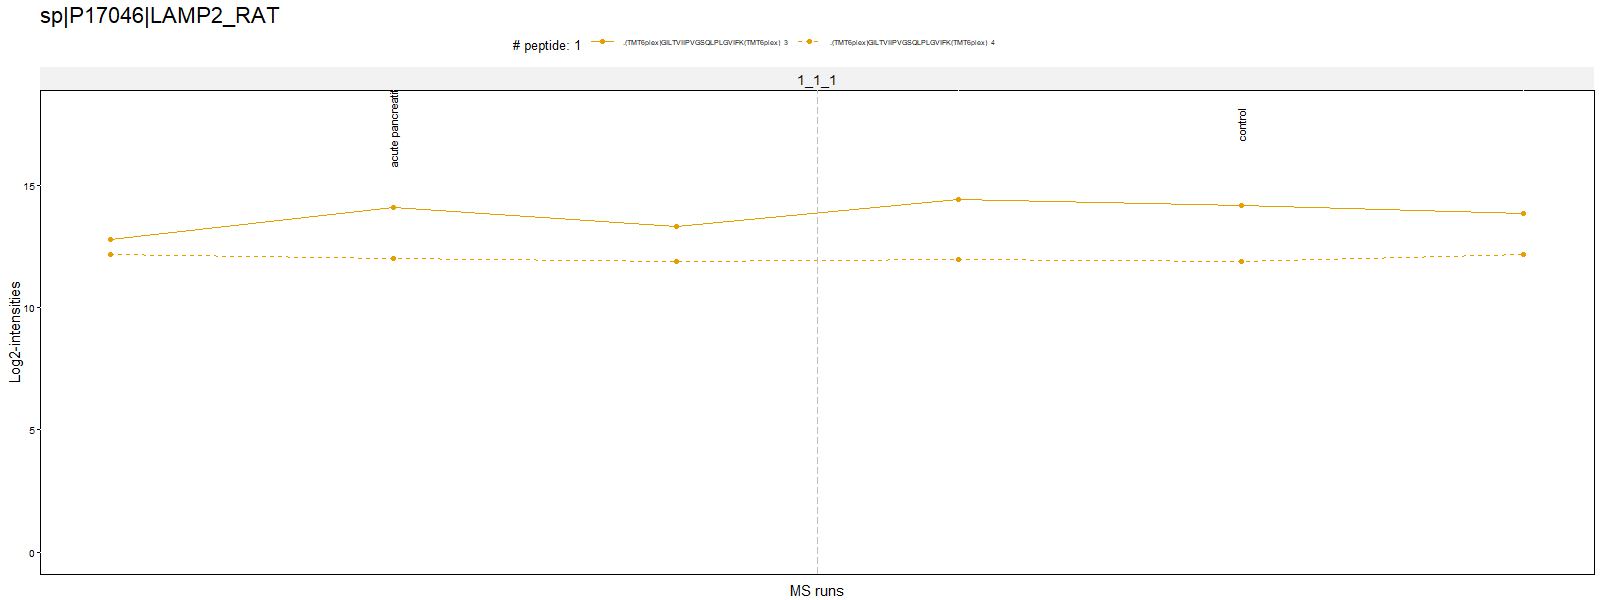

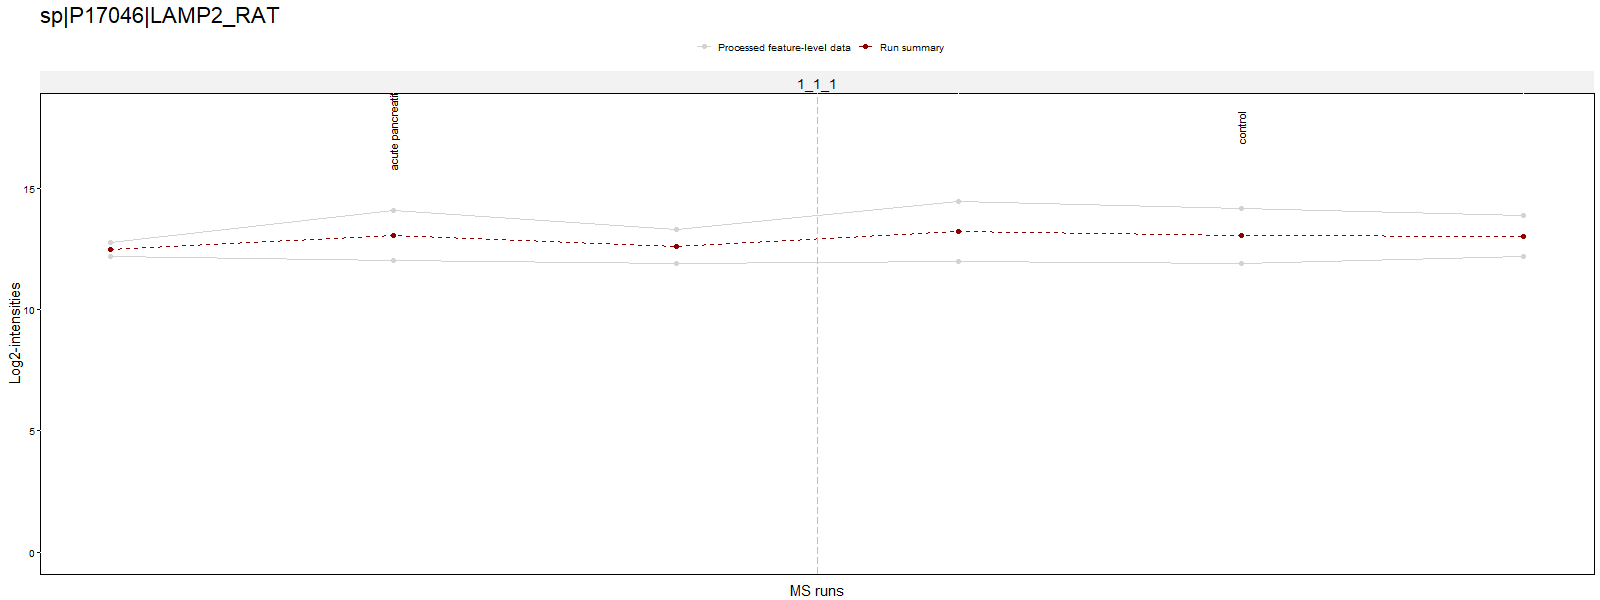

In [5]:
%%R -w 1600 -h 600

protein_expression = './protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P17046|LAMP2_RAT',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



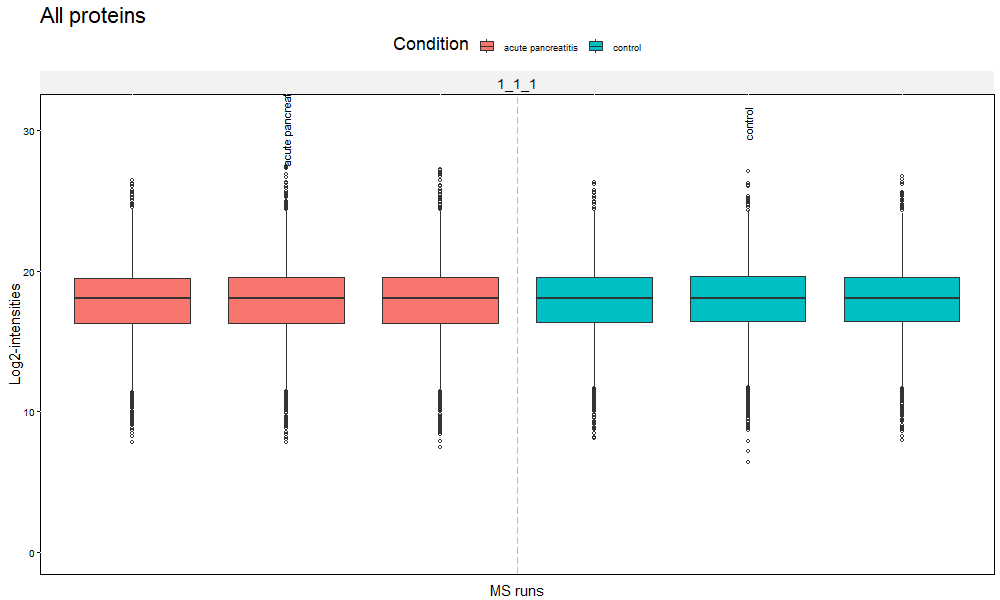

In [6]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)

## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

### Tests for significant changes in protein abundance across conditions

In [7]:
%%R
# Check the conditions in the protein level data
levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "acute pancreatitis" "control"           


In [8]:
%%R -w 1000 -h 600

Cancer_Normal_Comp<-matrix(c(1, -1),nrow=1)
row.names(Cancer_Normal_Comp)<-c("acute pancreatitis vs control")
colnames(Cancer_Normal_Comp) = c("acute pancreatitis","control")


Cancer_Normal_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cancer_Normal_Comp, moderated = TRUE)

INFO  [2021-10-21 11:23:43] Model fitting for 908 proteins.
  |======================================================================| 100%
INFO  [2021-10-21 11:23:49] Testing for 908 proteins:
  |======================================================================| 100%


In [9]:
%%R

head(Cancer_Normal_Comp.pairwise$ComparisonResult)

                                                                                                                                                       Protein
1:                                                                                                                                     sp|A0A0G2K1Q8|ABCA3_RAT
2:                                                                                                                                          sp|A0JPJ7|OLA1_RAT
3:                                                                                                                                         sp|A0JPM9|EIF3J_RAT
4:                                                                                                                                          sp|A7VJC2|ROA2_RAT
5: sp|A9UMV8|H2AJ_RAT;sp|P02262|H2A1_RAT;sp|P0C169|H2A1C_RAT;sp|P0C170|H2A1E_RAT;sp|P0CC09|H2A2A_RAT;sp|Q00728|H2A4_RAT;sp|Q4FZT6|H2A3_RAT;sp|Q64598|H2A1F_RAT
6:                                            

#### Visualization acute pancreatitis vs Normal Condition

In [10]:
%%R

Cancer_Normal_Comp = Cancer_Normal_Comp.pairwise$ComparisonResult
write.table(Cancer_Normal_Comp,"Soluble_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")

In [11]:
# map protein to gene name
import re
import urllib.parse
import urllib.request

def MapProtGeneName(prots):
    url = 'https://www.uniprot.org/uploadlists/'
    query = ' '.join(prots)
    params = {
    'from': 'ACC+ID',
    'to': 'GENENAME',
    'format': 'tab',
    'query':query
    }

    data = urllib.parse.urlencode(params)
    data = data.encode('utf-8')
    req = urllib.request.Request(url, data)
    with urllib.request.urlopen(req) as f:
        response = f.read()
        data = response.decode('utf-8')
        r = {}
        keys = re.split('\t|\n', data)[::2][1:-1]
        values = re.split('\t|\n', data)[1::2][1:]
        for i in range(len(keys)):
            if keys[i] in r:
                r[keys[i]] = r[keys[i]] + "/" + values[i]
            else:
                r[keys[i]] = values[i]     
    return r

                                             Protein  \
0                            sp|A0A0G2K1Q8|ABCA3_RAT   
1                                 sp|A0JPJ7|OLA1_RAT   
2                                sp|A0JPM9|EIF3J_RAT   
3                                 sp|A7VJC2|ROA2_RAT   
4  sp|A9UMV8|H2AJ_RAT;sp|P02262|H2A1_RAT;sp|P0C16...   

                           Label    log2FC    pvalue  -Log10(p-value)  \
0  acute pancreatitis vs control -0.969125  0.002654         2.576085   
1  acute pancreatitis vs control  0.263631  0.081665         1.087965   
2  acute pancreatitis vs control  0.362955  0.540736         0.267015   
3  acute pancreatitis vs control -0.162050  0.388170         0.410978   
4  acute pancreatitis vs control -0.134704  0.568082         0.245589   

      group  
0  tab:blue  
1   dimgrey  
2   dimgrey  
3   dimgrey  
4   dimgrey  


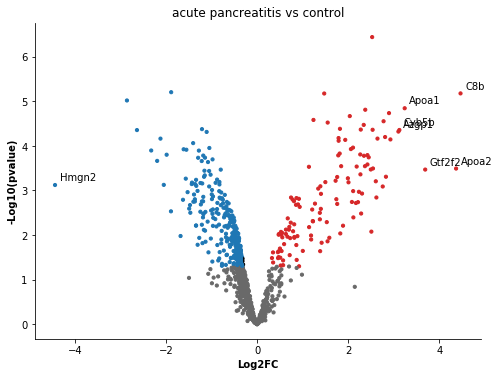

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import math

def preprocess(s):
    return s.split('|')[-1]

result = pd.read_csv('./Soluble_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > math.log2(1.25))&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < math.log2(0.8))&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    ax.set_title(comp)
    i += 1
    
    g = MapProtGeneName(list(map(preprocess, data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)]['Protein'].tolist())))
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 3)].iterrows():
        ax.annotate(g[preprocess(row['Protein'])], xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

#### Comparing differentially expressed proteins

##### Most of differentially expressed proteins given in the article are in out results, and we qutified more differentially expressed proteins

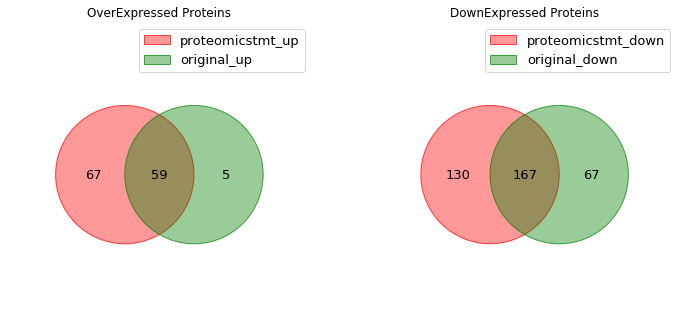

In [23]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from venn import venn

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
result = pd.read_csv('./Soluble_Comp_result.csv', sep=',')
original_soluble_result = pd.read_excel("./Soluble_fraction.xlsx", sheet_name="Quantifications")
original_soluble_up = original_soluble_result[(original_soluble_result["Is Significant"])&
                                              (original_soluble_result["Ratio"] > 1.0)]["ID"]
original_soluble_down = original_soluble_result[(original_soluble_result["Is Significant"])&
                                              (original_soluble_result["Ratio"] < 1.0)]["ID"]

t = result[result["Label"] == "acute pancreatitis vs control"]
t["ID"] = t.apply(lambda x: x.Protein.split('|')[-1], axis=1)
soluble_over_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] > 0)]["ID"]
soluble_under_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] < 0)]["ID"]

axs[0].set_title("OverExpressed Proteins")
venn({"proteomicstmt_up": set(soluble_over_expressed), "original_up": set(original_soluble_up)}, ax=axs[0], cmap=['r', 'g'])

axs[1].set_title("DownExpressed Proteins")
venn({"proteomicstmt_down": set(soluble_under_expressed), "original_down": set(original_soluble_down)}, ax=axs[1], cmap=['r', 'g'])

### Membrane fraction

#### Compared with the original picture, the overlapping part of the differential protein is too small. But we found more and more significant difference proteins

In [24]:
%%R -w 800 -h 600

openms_output = './out_msstats_membrane.csv'

raw.om <- read.csv(openms_output, header = TRUE, sep = ',')

raw.om$Condition[which(raw.om$Condition == "membrane fraction of pancreas|control")] <- "control"
raw.om$Condition[which(raw.om$Condition == "membrane fraction of pancreas|acute pancreatitis")] <- "acute pancreatitis"

input.om <- OpenMStoMSstatsTMTFormat(raw.om)


INFO  [2021-10-21 14:17:08] ** Raw data from OpenMS imported successfully.
INFO  [2021-10-21 14:17:08] ** Raw data from OpenMS cleaned successfully.
INFO  [2021-10-21 14:17:08] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2021-10-21 14:17:08] ** Features with all missing measurements across channels within each run are removed.
INFO  [2021-10-21 14:17:09] ** Shared peptides are removed.
INFO  [2021-10-21 14:17:09] ** Features with one or two measurements across channels within each run are removed.
INFO  [2021-10-21 14:17:15] ** PSMs have been aggregated to peptide ions.
INFO  [2021-10-21 14:17:16] ** For peptides overlapped between fractions of 2_2_2 use the fraction with maximal average abundance.
INFO  [2021-10-21 14:17:16] ** Fractions belongin

INFO  [2021-10-21 14:24:51] ** MSstatsTMT - proteinSummarization function
INFO  [2021-10-21 14:24:51] Summarizing for Run : 2_2_2 ( 1  of  1 )
  |======================================================================| 100%
INFO  [2021-10-21 14:25:02] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


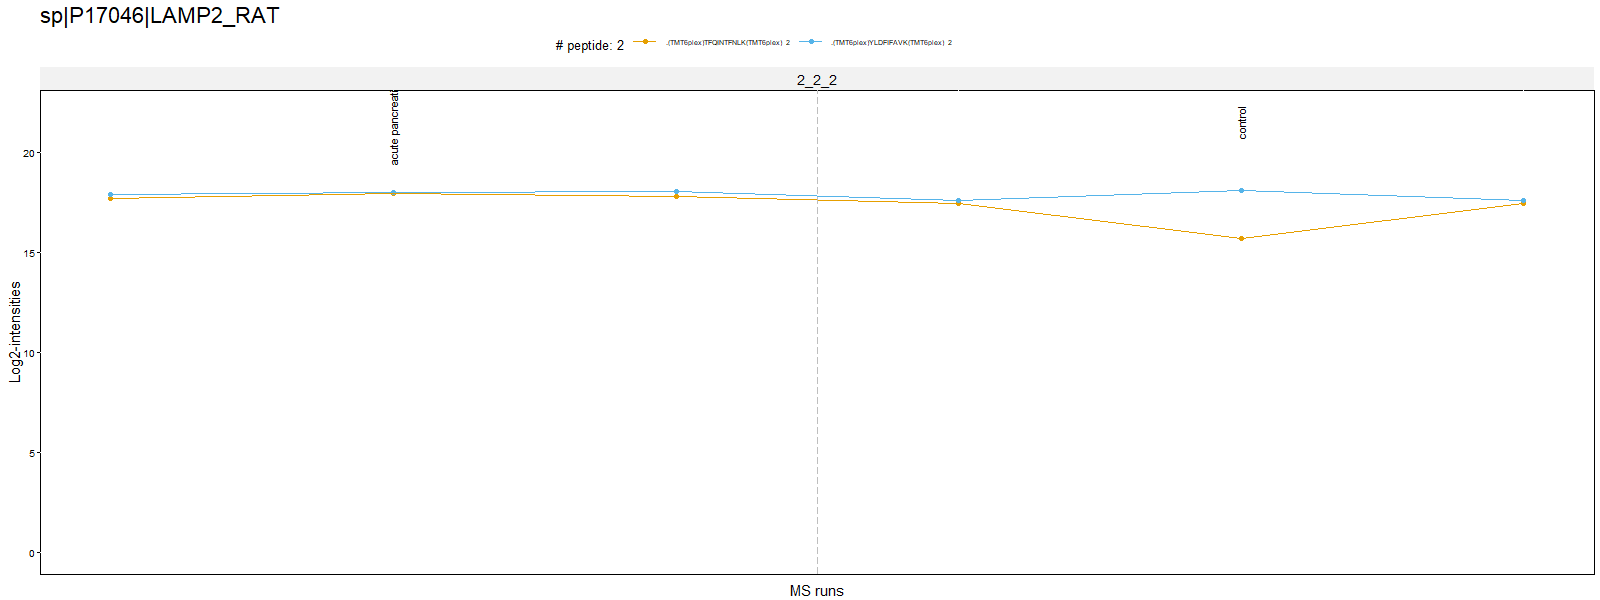

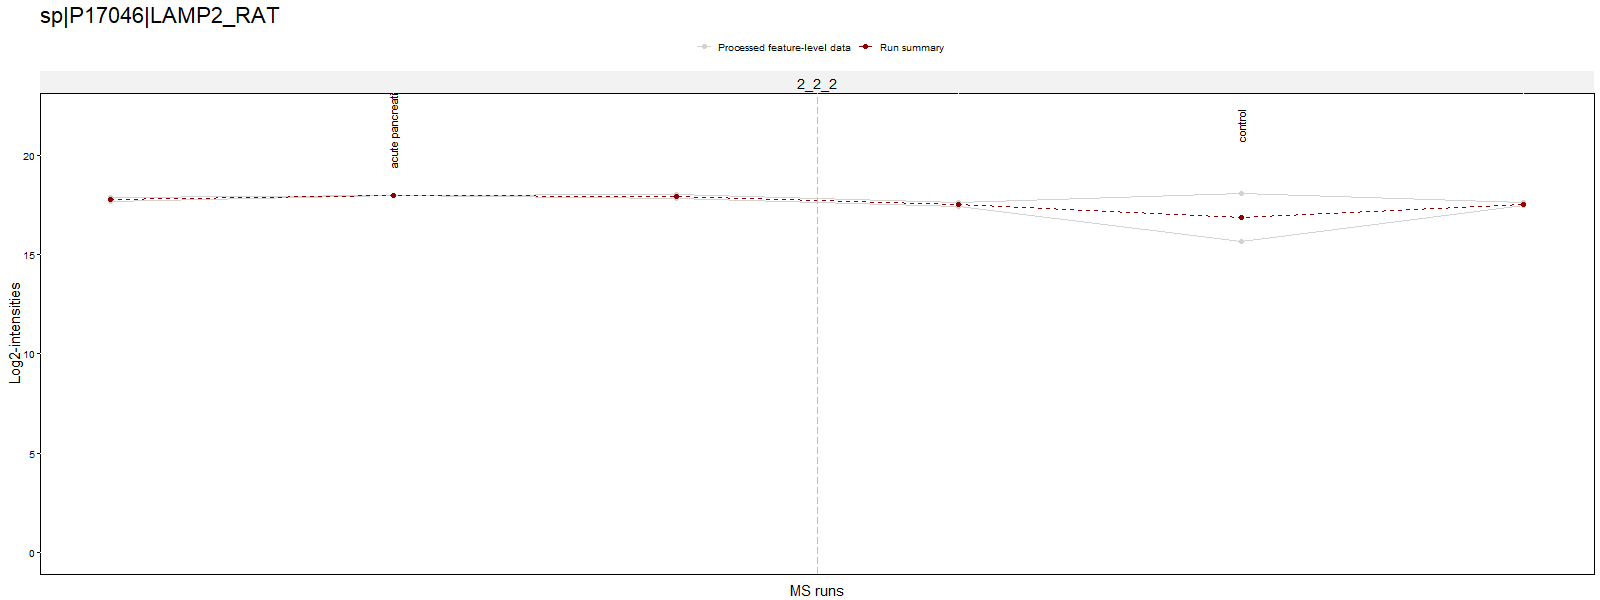

In [25]:
%%R -w 1600 -h 600

protein_expression = './membrane_protein_expression.csv'

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P17046|LAMP2_RAT',
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)
TMTProtein.Expression <- quant_om.msstats$ProteinLevelData[, c('Protein', 'Abundance', 'Condition')]

write.csv(TMTProtein.Expression, file=protein_expression, row.names=FALSE)



R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



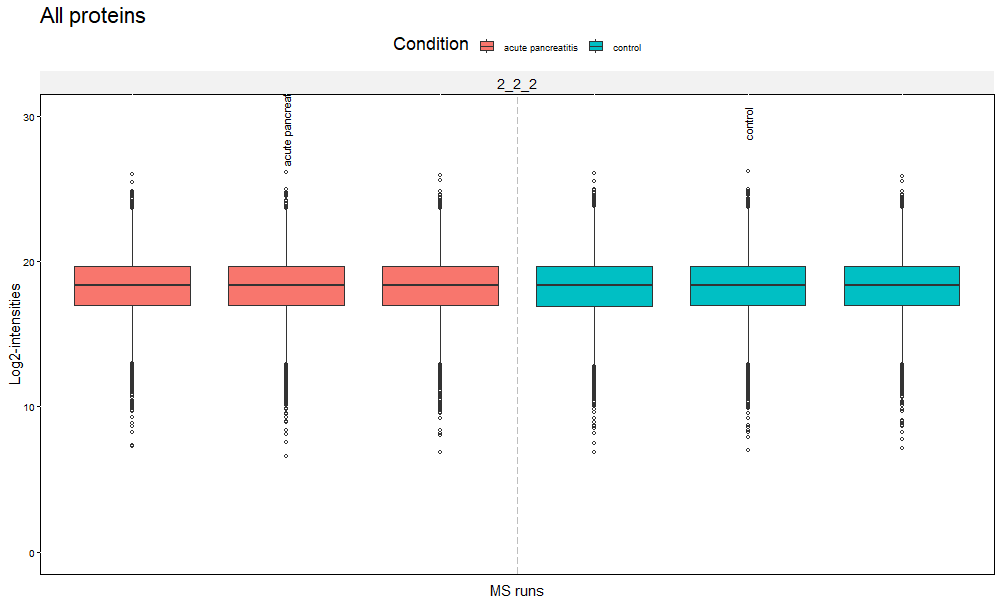

In [26]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)

## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)


In [27]:
%%R -w 1000 -h 600

levels(quant_om.msstats$ProteinLevelData$Condition)

Cancer_Normal_Comp<-matrix(c(1, -1),nrow=1)
row.names(Cancer_Normal_Comp)<-c("acute pancreatitis vs control")
colnames(Cancer_Normal_Comp) = c("acute pancreatitis","control")

Cancer_Normal_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = Cancer_Normal_Comp, moderated = TRUE)
Cancer_Normal_Comp = Cancer_Normal_Comp.pairwise$ComparisonResult
write.table(Cancer_Normal_Comp,"Membrane_Comp_result.csv",row.names=FALSE,col.names=TRUE,sep=",")


INFO  [2021-10-21 14:29:17] Model fitting for 1070 proteins.
  |======================================================================| 100%
INFO  [2021-10-21 14:29:24] Testing for 1070 proteins:
  |======================================================================| 100%


                   Protein                          Label    log2FC    pvalue  \
0  sp|A0A0G2JUG7|IQEC1_RAT  acute pancreatitis vs control  0.205692  0.094560   
1  sp|A0A0G2K047|ACSS3_RAT  acute pancreatitis vs control  0.246938  0.154557   
2  sp|A0A0G2K1Q8|ABCA3_RAT  acute pancreatitis vs control -0.095749  0.861847   
3       sp|A0JPJ7|OLA1_RAT  acute pancreatitis vs control -1.270391  0.000032   
4      sp|A0JPL0|ZN382_RAT  acute pancreatitis vs control  0.115114  0.392775   

   -Log10(p-value)     group  
0         1.024291   dimgrey  
1         0.810911   dimgrey  
2         0.064570   dimgrey  
3         4.498634  tab:blue  
4         0.405856   dimgrey  


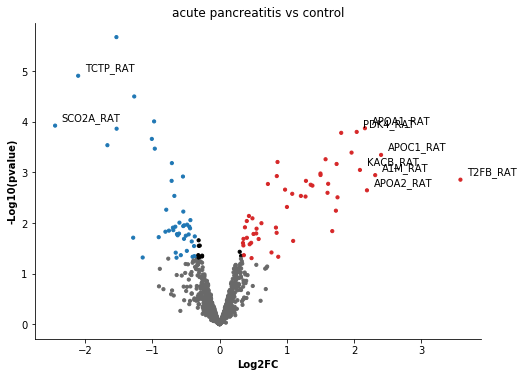

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np 
from matplotlib import pyplot as plt
import math

def preprocess(s):
    return s.split('|')[-1]

result = pd.read_csv('./Membrane_Comp_result.csv', sep=',')
result = result[['Protein', 'Label', 'log2FC', 'pvalue']].dropna()
result["-Log10(p-value)"] = -np.log10(result['pvalue'])

#up, normal, down
result['group'] = 'black'
result.loc[(result['log2FC'] > math.log2(1.25))&(result['pvalue'] < 0.05),'group'] = 'tab:red' 
result.loc[(result['log2FC'] < math.log2(0.8))&(result['pvalue'] < 0.05),'group'] = 'tab:blue'
result.loc[result['pvalue'] >= 0.05,'group'] = 'dimgrey'
print(result.head())

xmin=-2
xmax=2
ymin=-2
ymax=10
fig = plt.figure(figsize=(8, 32))
i = 1
for comp in np.unique(result['Label']):
    data = result[result['Label'] == comp]
    ax = fig.add_subplot(410 + i)
    ax.scatter(data['log2FC'], data["-Log10(p-value)"], s=10, c=data['group'])
    ax.set_ylabel('-Log10(pvalue)',fontweight='bold')
    ax.set_xlabel('Log2FC',fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    
    ax.set_title(comp)
    i += 1
    
    for _,row in data[(data['group'] != 'dimgrey')&(np.abs(data['log2FC']) > 2)].iterrows():
        ax.annotate(preprocess(row['Protein']), xy = (row['log2FC'], row['-Log10(p-value)']), 
                    xytext = (row['log2FC']+0.1, row['-Log10(p-value)']+0.1))
    
plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.show()

#### comparing differentially expressed proteins

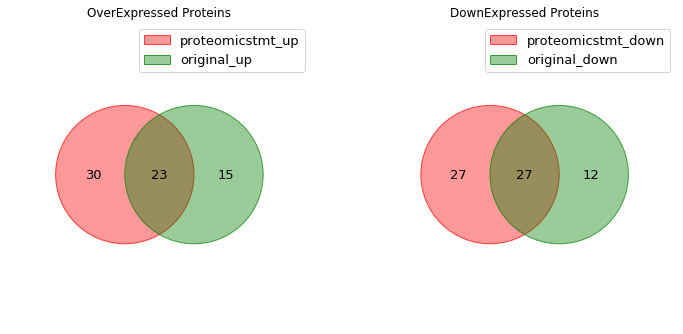

In [31]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from venn import venn

_, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
result = pd.read_csv('./Membrane_Comp_result.csv', sep=',')
original_membrane_result = pd.read_excel("./Membrane_fraction.xlsx", sheet_name="Quantifications")
original_membrane_up = original_membrane_result[(original_membrane_result["Is Significant"])&
                                              (original_membrane_result["Ratio"] > 1.0)]["ID"]
original_membrane_down = original_membrane_result[(original_membrane_result["Is Significant"])&
                                              (original_membrane_result["Ratio"] < 1.0)]["ID"]

t = result[result["Label"] == "acute pancreatitis vs control"]
t["ID"] = t.apply(lambda x: x.Protein.split('|')[-1], axis=1)
soluble_over_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] > 0)]["ID"]
soluble_under_expressed = t[(t['pvalue'] < 0.05)&(t['log2FC'] < 0)]["ID"]

axs[0].set_title("OverExpressed Proteins")
venn({"proteomicstmt_up": set(soluble_over_expressed), "original_up": set(original_membrane_up)}, ax=axs[0], cmap=['r', 'g'])

axs[1].set_title("DownExpressed Proteins")
venn({"proteomicstmt_down": set(soluble_under_expressed), "original_down": set(original_membrane_down)}, ax=axs[1], cmap=['r', 'g'])